In [16]:
import plotly.graph_objects as go
import pandas as pd

import matplotlib.pyplot as plt
import networkx as nx

# reading input log file
import math
import sys
import traceback
from csv import excel
from collections import Counter
from scipy import stats

path='../save_outputs/vol-vfd'
nshow=4

In [17]:
# data related methods
def humansize(nbytes):
    suffixes = ['B', 'KB', 'MB', 'GB', 'TB', 'PB']
    i = 0
    while nbytes >= 1000 and i < len(suffixes)-1:
        nbytes /= 1000.
        i += 1
    f = ('%.2f' % nbytes).rstrip('0').rstrip('.')
    return '%s %s' % (f, suffixes[i])

def check_empty(df,p=True):
    nan_df = df[df.isna().any(axis=1)].copy()
    if not nan_df.empty:
        if p:
            print(f"NaN rows: {nan_df}") # check any nan
        return list(nan_df.index)
    
    null_df = df[df.isnull().any(axis=1)].copy()
    if not null_df.empty:
        if p:
            print(f"NULL rows: {null_df}") # check any null
        return list(null_df.index)
    
def print_list_diff(list1, list2):
    if list1 == list2:
        print("same lists")
    else:
        print("different lists\nindex:\t[list1]\t[list2]")
        for index, (first, second) in enumerate(zip(list1, list2)):
            if first != second:
                # print(index, first, second)
                print(f"{index}:\t{first}]\t[{second}]")

def df_to_csv(df,file_name,suffix=''):
    # df.hash_id=df.hash_id.astype('category').cat.codes
    # out_csv=file_name.replace('prov-vfd-','')
    out_csv=file_name.replace('.csv',f'{suffix}.csv')
    df.to_csv(out_csv,index=False)
    
def read_data(filename, dset=''):
    if '.parquet' in filename:
        df = pd.read_parquet(filename,engine='pyarrow')
    if'.csv' in filename:
        df = pd.read_csv(filename,index_col=False)
    
    if len(dset) > 0:
        df = df[df['dset_name'] == dset]
        
    return df

In [18]:
# networkx related methods
COLOR_MAP = {"task": "#ab2626", # read
            "vol": "#fc8403", #orange
            "contact_map": "#bd6f1c", # darker orange
            "point_cloud": "#bd9060", # darker and less op orange
            "addr": "#5c95e0", # blue
            "logical_addr": "#69b3d6", #light blue
            "logical_addr_vfd": "#699ad6", # slightly different light lue
            "file": "#234dd9", # darker blue
            "read": "#bf7777", # light read
            "write": "#b277bf", #light purpul
            "none": "grey",
            }

EDGE_COLOR_MAP = {"create": "rgba(0, 0, 0, 0.41)", # grey
            "get": "rgba(0, 0, 0, 0.41)", #grey
            "read": "rgba(232, 39, 245, 0.41)", # light megenta
            "write": "rgba(129, 39, 245, 0.41)", # light purple
            "open": "rgba(0, 0, 0, 0.41)", # grey
            "close": "rgba(0, 0, 0, 0.41)" # grey
            }

def rm_name_tags(name, tags):
    for t in tags:
        name = str(name).replace(f"{t}-","")
        name = str(name).replace("vol-","")
        name = str(name).replace("contact_map","cm")
        name = str(name).replace("point_cloud","pc")
    return name

def draw_graph(G,color_map=COLOR_MAP, rm_tags=['']):
    pos=nx.get_node_attributes(G,'pos')
    names = nx.get_node_attributes(G,'name')

    node_colors = [] 
    # set node colors
    for name in names.values():
        _n = rm_name_tags(name, rm_tags)
        node_colors.append(color_map[_n])
        
    # set node labels
    labels = {}
    for node in names.keys():
        _n = rm_name_tags(node, rm_tags)
        labels[node] = _n
            
        # if 'addr' in names[node]:
        #     labels[node] = f'addr : {_n}'
        # else:
        #     labels[node] = _n

    plt.figure(figsize=(25, 10)) #figsize=(40, 10)
    
    bbox = dict(alpha=0.6, fc="black", ec="white", boxstyle="square", color='white') #fc="red", , lw=3
        
    nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors)
    nx.draw_networkx_labels(G, pos=pos, labels= labels, bbox=bbox, horizontalalignment='left', font_color='white')
    
    for edge in G.edges(data='access_cnt'):
        nx.draw_networkx_edges(G, pos=pos, edgelist=[edge], width=edge[2], )
    
    plt.axis("off")
    plt.margins(x=0.1)
    
    out_tag = '-'.join(rm_tags)
    plt.savefig(f"{path}/networkx-sampled-{out_tag}.png")
    
    plt.show()
    

def add_attr_dic_edges(G,edges, acc_idx_list, asize, ops):
    # df.groupby(['ColA','ColB']).size().reset_index(name='Count')
    attr_dict = {}
    edge_cnt = {}
    for i, e in enumerate(edges):
        if e in edge_cnt.keys():
            if (edge_cnt[f'{e}-acc'] != acc_idx_list[i]):
                edge_cnt[e] +=1
            elif 'meta' in e[0] or 'meta' in e[1]:
                edge_cnt[e] +=1
            # print(f"e[0] = {e[0]} , e[1] = {e[1]}, edge_cnt[e] = {edge_cnt[e]}")
        else:
            edge_cnt[e] = 1
            edge_cnt[f'{e}-acc'] = acc_idx_list[i]
    
    for i, e in enumerate(edges):
        try:
            attr_dict[e] = {'access_cnt': edge_cnt[e], 'access_size': asize[i], 'operation': ops[i]}
        except:
            print(f"i={i} edge={e}")
            # print(asize)
            # print(ops)
            traceback.print_exc()
            # break
    G.add_edges_from(edges)
    nx.set_edge_attributes(G,attr_dict)

def add_nodes_edges(G, l1, l2, io_idx, ops, acc_s=[], x_pos=0, tags=['','']):
    #column1, column2, io_access_idx, access_size
    _x = x_pos
    _y = -1
    
    l1t = ['-'.join((tags[0],str(x))) for x in l1]
    l2t = ['-'.join((tags[1],str(x))) for x in l2]
    
    for i, l in enumerate([l1t, l2t]):
        _addr_pos = []
        if 'addr' in tags[i]:
            org_vals = [float(x.split('-')[-1]) for x in l]
            _addr_pos = stats.rankdata(org_vals,method='dense')
    
        for j,n in enumerate(l):
            if(G.has_node(n) == False):
                _y+=1
                if len(_addr_pos) > 0:
                    G.add_node(n,pos=(_x,_addr_pos[j]),name=tags[i])
                else:
                    G.add_node(n, pos=(_x,_y), name=tags[i])
        _x+=1
    
    if len(l1t) == 1:
        l1t = l1t * len(l2t)
    if len(l2t) == 1:
        l2t = l2t * len(l1t)
    if len(acc_s) == 0:
        acc_s = [1] * len(l1t)
    add_attr_dic_edges(G, list(zip(l1t, l2t)), io_idx,acc_s,ops)

In [19]:
fsim='../save_outputs/vol-vfd/prov-vfd-sim-merged.csv'

df_sim_merged = read_data(fsim)

print(df_sim_merged.columns)
# print(df_sim_merged[df_merged['data_la# print(df_merged[df_merged['data_label_vol'].str.match('vol-data-contact_map-1')])

df_sim = pd.concat([df_sim_merged.head(nshow),df_sim_merged.iloc[175:(175+nshow)], df_sim_merged.iloc[443:(443+nshow)],df_sim_merged.tail(nshow)])

G_SIM = nx.DiGraph()

add_nodes_edges(G_SIM, ['sim_emulator'], list(df_sim['data_label_vol']), 
                    list(df_sim['io_access_idx_vol']),
                    list(df_sim['operation_vol']), acc_s=list(df_sim['access_size_vol']),
                    x_pos=0, tags=['task','sim-vol'])

add_nodes_edges(G_SIM, list(df_sim['data_label_vol']), list(df_sim['logical_addr_vfd']), 
                    list(df_sim['io_access_idx_vfd']),
                    list(df_sim['operation_vol']), acc_s=list(df_sim['access_size_vfd']),
                    x_pos=1, tags=['sim-vol','sim-addr'])

add_nodes_edges(G_SIM, list(df_sim['logical_addr_vfd']), ['residue.h5'], 
                    list(df_sim['io_access_idx_vfd']),
                    list(df_sim['operation_vol']), acc_s=list(df_sim['access_size_vfd']),
                    x_pos=2, tags=['sim-addr','file'])

# print(nx.get_node_attributes(G_SIM,'pos'))
# print(nx.get_edge_attributes(G_SIM,'access_cnt'))
# print(nx.get_edge_attributes(G_SIM,'operation'))


Index(['data_label_vol', 'io_access_idx_vol', 'dset_name', 'access_size_vol',
       'op_type_vol', 'logical_addr', 'operation_vol', 'n_elements',
       'dimension_cnt', 'dimensions', 'file_intent', 'layout', 'time(us)_vol',
       'logical_addr_map', 'data_label_vfd', 'io_access_idx_vfd',
       'access_size_vfd', 'op_type_vfd', 'logical_addr_vfd', 'file_name',
       'time(us)_vfd', 'operation_vfd'],
      dtype='object')


In [20]:
print(list(df_sim['access_size_vfd']))
print(nx.get_edge_attributes(G_SIM,'access_size'))

[0.0, 40.0, 328.0, 544.0, 0.0, 0.0, 40.0, 328.0, 37408.0, 37184.0, 37512.0, 37608.0, 36840.0, 37064.0, 37360.0, 2400000.0]
{('task-sim_emulator', 'sim-vol-vol-meta-contact_map'): 0, ('task-sim_emulator', 'sim-vol-vol-meta-point_cloud'): 0, ('task-sim_emulator', 'sim-vol-vol-data-contact_map-1'): 37372, ('task-sim_emulator', 'sim-vol-vol-data-contact_map-2'): 37148, ('task-sim_emulator', 'sim-vol-vol-data-contact_map-3'): 37476, ('task-sim_emulator', 'sim-vol-vol-data-contact_map-4'): 37572, ('task-sim_emulator', 'sim-vol-vol-data-contact_map-998'): 36804, ('task-sim_emulator', 'sim-vol-vol-data-contact_map-999'): 37028, ('task-sim_emulator', 'sim-vol-vol-data-contact_map-1000'): 37324, ('task-sim_emulator', 'sim-vol-vol-data-point_cloud-0'): 2400000, ('sim-vol-vol-meta-contact_map', 'sim-addr-0.0'): 0.0, ('sim-vol-vol-meta-contact_map', 'sim-addr-96.0'): 40.0, ('sim-vol-vol-meta-contact_map', 'sim-addr-1072.0'): 328.0, ('sim-vol-vol-meta-contact_map', 'sim-addr-136.0'): 544.0, ('sim-vo

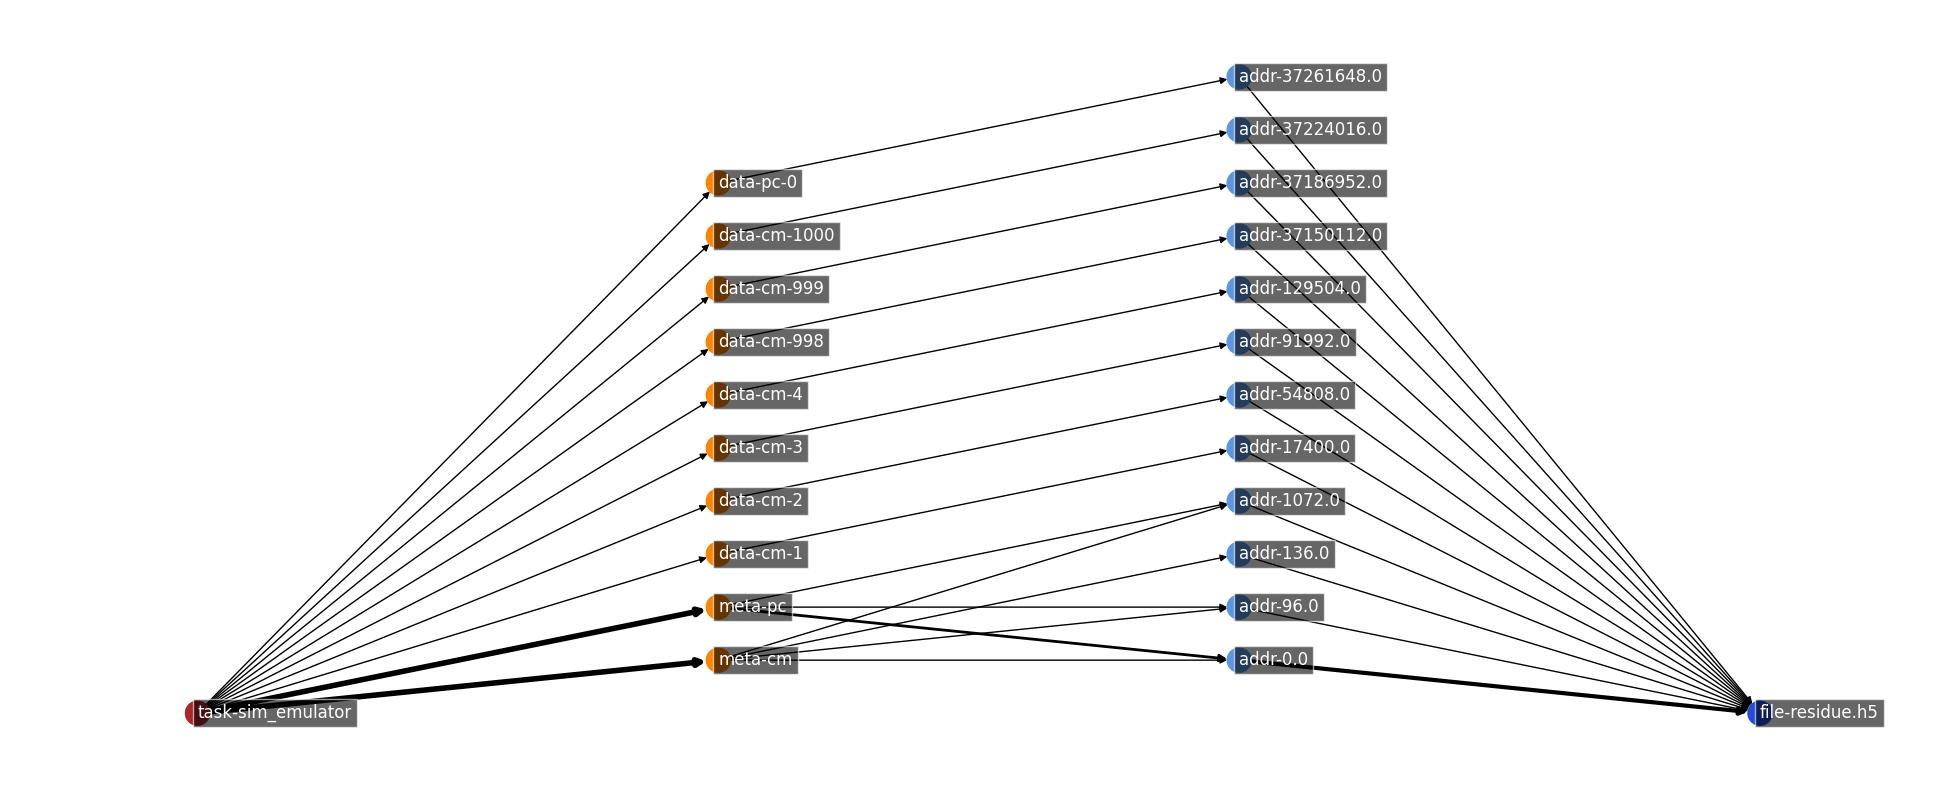

In [21]:
# find and add more attributes for task and file nodes
task_attr = {'task-sim_emulator': {'file_intent':df_sim_merged['file_intent'].iloc[0]}}
nx.set_node_attributes(G_SIM,task_attr)
# attr for edges ['operation']
# attr for dset nodes ['layout', 'dset_name', 'n_elements', 'dimension_cnt', 'dimensions', ]

draw_graph(G_SIM,COLOR_MAP,rm_tags=['sim'])


In [22]:
fagg_read='../save_outputs/vol-vfd/prov-vfd-agg-read-merged.csv'

df_agg_read_merged = read_data(fagg_read)

print(df_agg_read_merged.columns)

# print(df_agg_read_merged[df_agg_read_merged['data_label_vol'].str.match('vol-data-contact_map-1')])
# print(df_agg_read_merged[df_agg_read_merged['data_label_vol'].str.match('vol-meta-point_cloud')])

df_agg_read = pd.concat([df_agg_read_merged.head(nshow),df_agg_read_merged.iloc[195:(195+nshow)], df_agg_read_merged.iloc[391:(391+nshow)],df_agg_read_merged.tail(nshow)])

# 'data_label_vol', 'data_label_vfd', 'logical_addr_vfd'
x_pos = max(nx.get_node_attributes(G_SIM,'pos').values())[0]

G_AGG_R = nx.DiGraph()

add_nodes_edges(G_AGG_R, ['residue.h5'], list(df_agg_read['logical_addr_vfd']), 
                    list(df_agg_read['io_access_idx_vfd']),
                    list(df_agg_read['operation_vol']), acc_s=list(df_agg_read['access_size_vfd']),
                    x_pos=x_pos, tags=['file','agg_r-addr'])
x_pos+=1
add_nodes_edges(G_AGG_R, list(df_agg_read['logical_addr_vfd']), list(df_agg_read['data_label_vol']), 
                    list(df_agg_read['io_access_idx_vol']),
                    list(df_agg_read['operation_vol']), acc_s=list(df_agg_read['access_size_vol']),
                    x_pos=x_pos, tags=['agg_r-addr','agg_r-vol'])

x_pos+=1
add_nodes_edges(G_AGG_R, list(df_agg_read['data_label_vol']), ['aggregator'], 
                    list(df_agg_read['io_access_idx_vol']),
                    list(df_agg_read['operation_vol']), acc_s=list(df_agg_read['access_size_vol']),
                    x_pos=x_pos, tags=['agg_r-vol','task'])

# print(nx.get_node_attributes(G_AGG_R,'pos'))
print(nx.get_edge_attributes(G_AGG_R,'operation'))

Index(['data_label_vol', 'io_access_idx_vol', 'dset_name', 'access_size_vol',
       'op_type_vol', 'logical_addr_vol', 'operation_vol', 'n_elements',
       'dimension_cnt', 'dimensions', 'file_intent', 'layout', 'time(us)_vol',
       'logical_addr_map', 'data_label_vfd', 'io_access_idx_vfd',
       'access_size_vfd', 'op_type_vfd', 'next_addr', 'logical_addr_vfd',
       'file_name', 'time(us)_vfd', 'operation_vfd'],
      dtype='object')
{('file-residue.h5', 'agg_r-addr-0.0'): 'open', ('file-residue.h5', 'agg_r-addr-16.0'): 'open', ('file-residue.h5', 'agg_r-addr-17400.0'): 'read', ('file-residue.h5', 'agg_r-addr-21496.0'): 'read', ('file-residue.h5', 'agg_r-addr-54808.0'): 'read', ('file-residue.h5', 'agg_r-addr-58904.0'): 'read', ('file-residue.h5', 'agg_r-addr-37191048.0'): 'read', ('file-residue.h5', 'agg_r-addr-37224016.0'): 'read', ('file-residue.h5', 'agg_r-addr-37228112.0'): 'read', ('file-residue.h5', 'agg_r-addr-37261648.0'): 'read', ('agg_r-addr-0.0', 'agg_r-vol-vol-meta

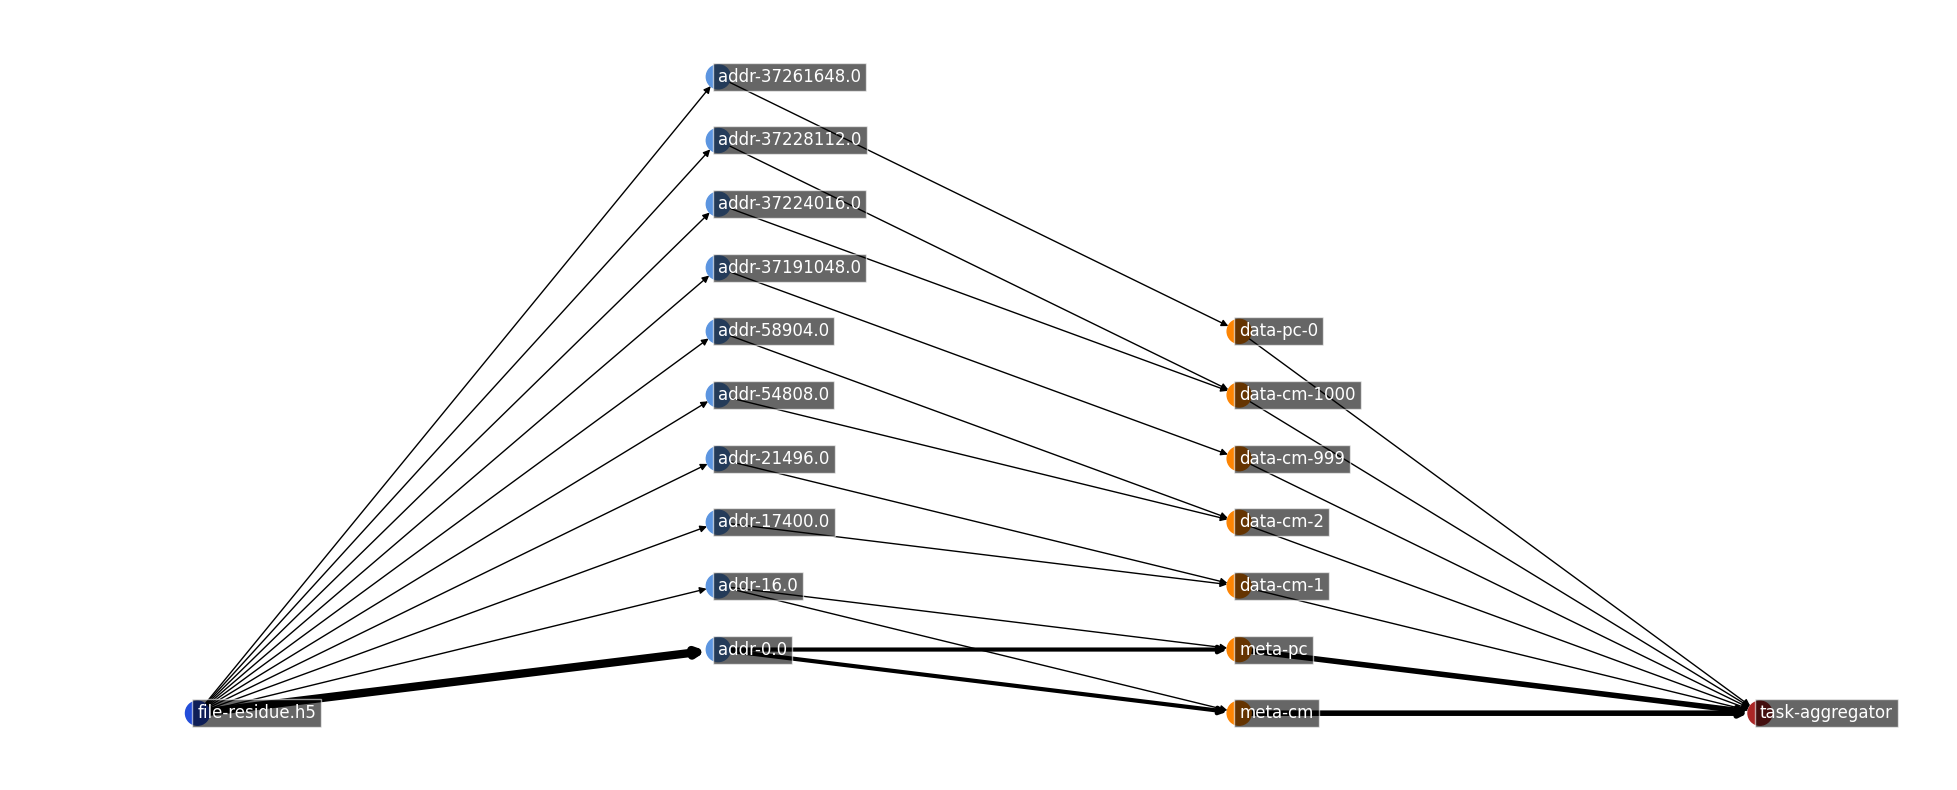

In [23]:
# G_AGG_R = get_graph(df_show,['logical_addr_vfd', 'data_label_vol'], source='residue_100.h5', sink='aggregator',tag='agg_r',x=x_pos, reverse=True)

# attr for edges ['operation']
# attr for dset nodes ['layout', 'dset_name', 'n_elements', 'dimension_cnt', 'dimensions', ]

draw_graph(G_AGG_R,COLOR_MAP, rm_tags=['agg_r'])
# find and add more attributes for task and file nodes

In [24]:
fagg_write='../save_outputs/vol-vfd/prov-vfd-agg-write-merged.csv'

df_agg_write_merged = read_data(fagg_write)

print(df_agg_write_merged.columns)

# print(df_agg_write_merged[df_agg_write_merged['data_label_vol'].str.match('vol-data-contact_map-1')])
# print(df_agg_write_merged[df_agg_write_merged['data_label_vol'].str.match('vol-meta-point_cloud')])

df_agg_write = pd.concat([df_agg_write_merged.head(nshow),df_agg_write_merged.iloc[88:(88+nshow)], df_agg_write_merged.iloc[233:(233+nshow)],df_agg_write_merged.tail(nshow)])

# 'data_label_vol', 'data_label_vfd', 'logical_addr'
x_pos = max(nx.get_node_attributes(G_AGG_R,'pos').values())[0]

G_AGG_W = nx.DiGraph()

add_nodes_edges(G_AGG_W, ['aggregator'], list(df_agg_write['data_label_vol']), 
                    list(df_agg_write['io_access_idx_vol']),
                    list(df_agg_write['operation_vol']), acc_s=list(df_agg_write['access_size_vol']),
                    x_pos=x_pos, tags=['task','agg_w-vol'])
x_pos+=1
add_nodes_edges(G_AGG_W, list(df_agg_write['data_label_vol']), list(df_agg_write['logical_addr_vfd']), 
                    list(df_agg_write['io_access_idx_vfd']),
                    list(df_agg_write['operation_vol']), acc_s=list(df_agg_write['access_size_vfd']),
                    x_pos=x_pos, tags=['agg_w-vol','agg_w-addr'])
x_pos+=1
add_nodes_edges(G_AGG_W, list(df_agg_write['logical_addr_vfd']), ['aggregate.h5'], 
                    list(df_agg_write['io_access_idx_vfd']),
                    list(df_agg_write['operation_vol']), acc_s=list(df_agg_write['access_size_vfd']),
                    x_pos=x_pos, tags=['agg_w-addr','file'])



Index(['data_label_vol', 'io_access_idx_vol', 'dset_name', 'access_size_vol',
       'logical_addr_vol', 'op_type_vol', 'operation_vol', 'n_elements',
       'dimension_cnt', 'dimensions', 'file_intent', 'layout', 'time(us)_vol',
       'logical_addr_map', 'data_label_vfd', 'io_access_idx_vfd',
       'access_size_vfd', 'logical_addr_vfd', 'next_addr', 'op_type_vfd',
       'file_name', 'time(us)_vfd', 'operation_vfd'],
      dtype='object')


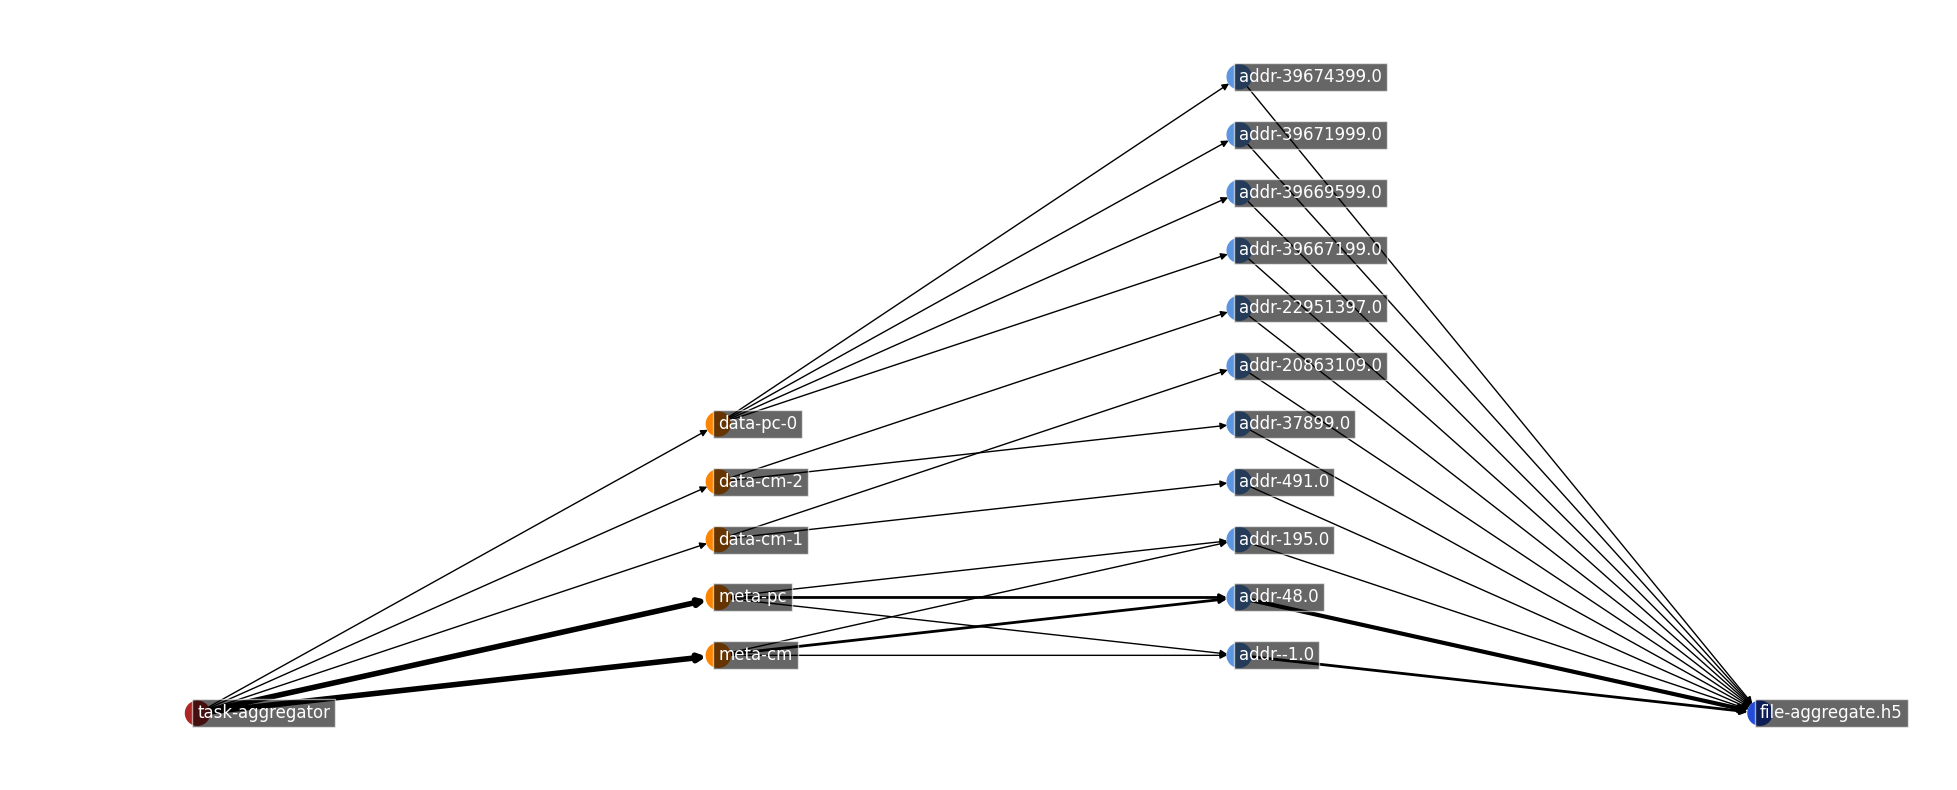

In [25]:
# print(nx.get_edge_attributes(G_AGG_W,'access_cnt'))
# test_df = df_agg_write_merged[df_agg_write_merged['data_label_vol'] == 'vol-data-point_cloud-0']
# print(test_df['io_access_idx_vol'])

# attr for edges ['operation']
# attr for dset nodes ['layout', 'dset_name', 'n_elements', 'dimension_cnt', 'dimensions', ]

task_attr = {'task-aggregator': {'file_intent':df_sim_merged['file_intent'].iloc[0]}}
nx.set_node_attributes(G_SIM,task_attr)

draw_graph(G_AGG_W,COLOR_MAP,rm_tags=['agg_w'])

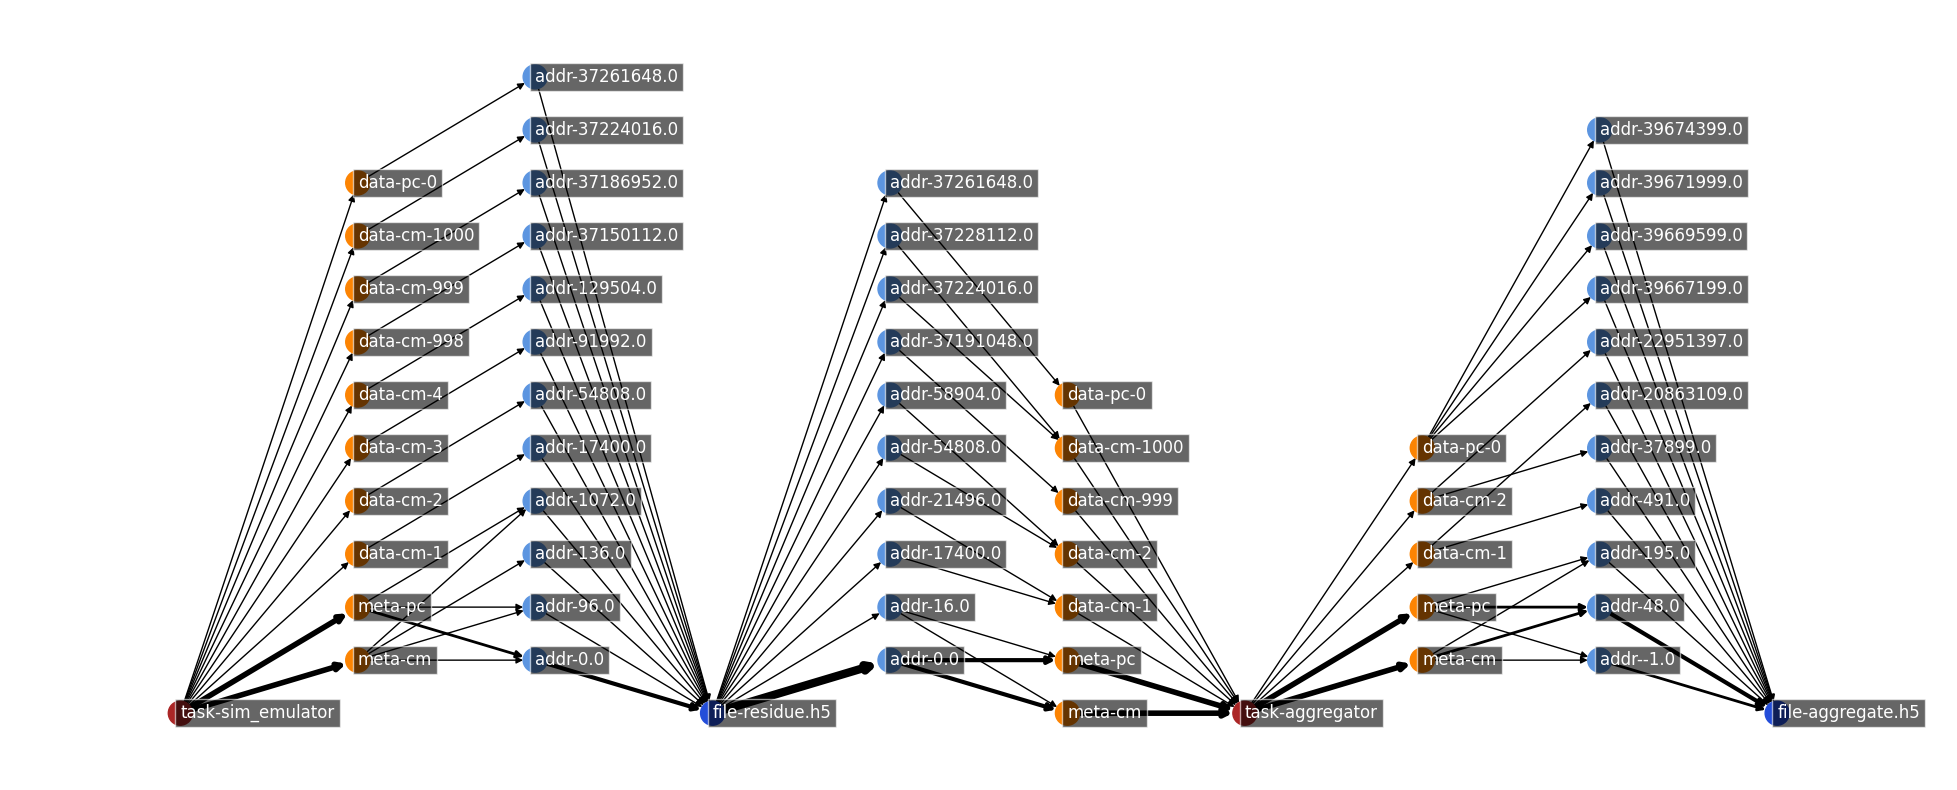

In [26]:
F1 = nx.compose(G_SIM,G_AGG_R)
# draw_graph(F1,COLOR_MAP,rm_tags=['sim','agg_r'])
F2 = nx.compose(F1, G_AGG_W)
draw_graph(F2,COLOR_MAP,rm_tags=['sim','agg_r','agg_w'])

In [27]:
# Sankey related codes
def get_xy_position(G):
    pos_dict = nx.get_node_attributes(G,'pos')

    x_dict = {}
    y_dict = {}
    for n, pos in pos_dict.items():
        x_dict[n] = pos[0]
        y_dict[n] = pos[1]
    
    xf=1.0/max(x_dict.values())
    x_pos = {k: v*xf for k, v in x_dict.items() }
    
    yf=1.0/max(y_dict.values())
    y_pos = {k: v*yf for k, v in y_dict.items() }
    # print(x_pos)
    # print(y_pos)
    
    return x_pos, y_pos

def get_nodes_for_sankey(G, rm_tags=[]):
    node_dict_ref = {}
    node_dict_for_sankey = {'label': [], 'color':[], 'x':[], 'y':[] }
    x_pos, y_pos = get_xy_position(G)
    
    for idx, (node_name, attr) in enumerate(G.nodes(data=True)):
        # node_type = 'file' if node_name[-4:] == 'residue_100.h5' else 'task'
        # print(f"{idx}, ({node_name}, {attr})")
        node_type = attr['name']
        if node_name in node_dict_ref:
            print(node_name, "==duplicate==")
        node_dict_ref[node_name] = {'idx':idx, 'type':node_type}

        #sankey
        node_dict_for_sankey['label'].append(rm_name_tags(node_name,rm_tags))
        node_dict_for_sankey['color'].append(COLOR_MAP[rm_name_tags(node_type,rm_tags)])
        node_dict_for_sankey['x'].append(x_pos[node_name])
        node_dict_for_sankey['y'].append(y_pos[node_name])
    return node_dict_for_sankey, node_dict_ref

def get_links_for_sankey(G, node_dict_ref,edge_attr=['access_cnt','access_size','operation'],rm_tags=[]):
    link_dict_for_sankey = {'source':[], 'target':[], 'value':[], 'label': [], 'color': [], 'hoverinfo': "all"}
    
    attr_cnt = nx.get_edge_attributes(G,edge_attr[0])
    attr_size = nx.get_edge_attributes(G,edge_attr[1])
    attr_op = nx.get_edge_attributes(G,edge_attr[2])
    
    # print(attr_dict)
    for u, v, attr in G.edges(data=True):
        # print(u, v, attr)
        u_idx = node_dict_ref[u]['idx']
        v_idx = node_dict_ref[v]['idx']
        link_dict_for_sankey['source'].append(u_idx)
        link_dict_for_sankey['target'].append(v_idx)
        link_dict_for_sankey['color'].append(EDGE_COLOR_MAP[attr_op[(u,v)]])
        # link_dict_for_sankey['value'].append(attr['weight])
        
        cnt = attr_cnt[(u,v)]
        size = attr_size[(u,v)]
        if size == 0:
            size = 1
        link_dict_for_sankey['value'].append(size)
        # _str = f"{edge_attr[0]}={cnt} {edge_attr[1]}={humansize(size)} ave_acc_size={humansize(size/cnt)}"
        _str = f"ave_acc_size: {humansize(size/cnt)}"

        link_dict_for_sankey['label'].append(_str)
        # link_dict_for_sankey['acc_cnt'].append(cnt)
        
    return link_dict_for_sankey

def selected_graph(node_name, G):
    # this is not used
    selected_G = nx.DiGraph()
    search_nodes = [node_name]
    while len(search_nodes) > 0:
        next_set = []
        for n in search_nodes:
            for edge in G.edges(n):
                val = G.edges[edge]['value']
                selected_G.add_edges_from([edge], value=val)
                #print(selected_G.nodes)
            next_set += [x for x in G.neighbors(n)]
        search_nodes = next_set
    return selected_G

In [28]:
sim_nodes, sim_nodes_dict = get_nodes_for_sankey(G_SIM, rm_tags=['sim'])

# print(node_ref2)

sim_links = get_links_for_sankey(G_SIM, sim_nodes_dict)
fig = go.Figure(go.Sankey(
            node = sim_nodes,
            link = sim_links, orientation='h'))
fig.show()
fig.write_html(f"{path}/sankey-sampled-sim_w-vol-vfd-.html")

In [29]:
# f1_nodes, f1_nodes_dict = get_nodes_for_sankey(F1,rm_tags=['sim','agg_r'])

# # print(node_ref2)

# f1_links = get_links_for_sankey(F1, f1_nodes_dict)
# fig = go.Figure(go.Sankey(
#             node = f1_nodes,
#             link = f1_links, orientation='h'))
# fig.show()
# fig.write_html(f"{path}/sankey-sim_w_agg_r-vol-vfd.html")

In [30]:
f2_nodes, f2_nodes_dict = get_nodes_for_sankey(F2,rm_tags=['sim','agg_r','agg_w'])

# print(node_ref2)

f2_links = get_links_for_sankey(F2, f2_nodes_dict)
fig = go.Figure(go.Sankey(
            node = f2_nodes,
            link = f2_links, orientation='h'))
fig.show()
fig.write_html(f"{path}/sankey-sampled-sim_w_agg_r_w-vol-vfd.html")